# Estimating Missing Political Data - machine learning techniques for pre/post processing

This lab will focus on handling missing data in a new way: leveraging some of the models you've learned to use.

In general this topic is more on the "art" side of the science/art spectrum, but there are some well-established ways to deal with and impute missing data, depending on what you want to accomplish in the end (increase the power, remove NaNs, impute with a numerical/label to prevent errors from your ML algorithms, etc.). 
	
Our overall goal is to see that there can be a "functional relationship" between the "missingness" of the data, and features found in our data. By doing this, we can categorize the kind of "missingness" we are dealing with for a particular dataset.

# Types of "Missingness" 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Types of "Missingness"
| Type  | Description  | 
|---|---|
 | Missing Completely at Random  | This is basically the best scenario, all NaN, NA, or blanks are distributed totally at random can be safely omitted  |
 | Missing at Random  | This is less strong, but is "random" given the sample you are using. This is what we're aiming at for our analysis; functionally, we want to show that our missing data isn't dependent on data we haven't observed or accounted for in our dataset   | 
 | Missing not at Random  | "There is a data generating process that yields missing values". Basically, it means there is some "pattern" to the 'missingness' |

# Introducing the Inclusion Indicator 

As stated, the type of “missingness” we are most concerned about is the last row, "Missing not at Random". If there is a data generating process, this means we can model the “missingness” in our data set. If we can convincingly show that this model accounts for "most" (we're not being stringent statisticians, so that word will be left up to you to define) of the observable variation, we can be (relatively) well-at-ease that our "missingness" isn't functionally related to some features we don't have control/accounted/recorded in our data.

Before we move forward, we have to define the "inclusion indicator". We say I is an inclusion indicator if : $$\begin{array}{cc}
  I=\{ & 
    \begin{array}{cc}
      1 & x: missing \\
      0 & x: \neg{missing} \\
    \end{array}
\end{array} $$

# Loading up data with missing values

We are going to load up polling data. However we will take the analysis much broader this time, and we will be using a version of the data set where we have not removed missing values... because after all, that's the point of this entire lab! 

So load up the data and the libraries we will need to get started!


#### Loading the data 

In [1]:
from __future__ import division
import os
import math
import pylab as py
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline



In [2]:
pre_poll = pd.read_csv('./assets/datasets/polls_new.csv')
del pre_poll['Unnamed: 0']
pre_poll.head()

,bush,state,edu,age
0,1,7,2,2
1,1,33,4,3
2,0,20,2,1
3,1,31,3,2
4,1,18,3,1


#### Problem 1 - Construct the Inclusion indicator and append the column to the table 

Build an 'inclusion' indicator column that will be 1 when bush is missing a value, and 0 otherwise.

In [3]:
pre_poll['bush_null'] = pre_poll['bush'].apply(lambda x: 1 if pd.isnull(x) else 0)
pre_poll['bush_null'].sum()

1978

In [15]:
pre_poll.iloc[:,1:-1]

,state,edu,age
0,7,2,2
1,33,4,3
2,20,2,1
3,31,3,2
4,18,3,1
5,31,4,2
6,40,1,3
7,33,4,2
8,22,4,2
9,22,4,3


#### Problem 2 - Prepare your data by converting it into numpy arrays

Some of our ML work will be better suited if the input data is contained in a numpy object.

In [4]:
from sklearn import preprocessing

bush_null = pre_poll['bush_null'].as_matrix()
poll_nd = pre_poll.iloc[:,1:-1].as_matrix() #dropping bush_null and bush from the data
type(poll_nd)

numpy.ndarray

#### Problem 3 - Split the data  70/30 train/test

Split the data in the ordinary way, making sure you have a 70/30 split.

In [5]:
from sklearn.cross_validation import train_test_split, cross_val_score


X_train, X_test, y_train, y_test = train_test_split(poll_nd, bush_null, test_size=0.30, random_state=50)


# Wait... how can we tell if something is "Missing not at random"? 

That's a good question. One way is to understand "how much" of the variation in your data your model is accounting for. We'll do some preliminary work on that front here, but I'm going to ask you to ask yourself:

1. How can I apply what I've learned in regressions to this problem? 
2. What are other metrics I could use to account for variation in data outside of regressions? 

One approach we've strongly pointed towards is to construct regression models with the inclusion indicator as a target, and see what sort of performance you can get out of those family of techniques. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from sklearn import metrics
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = metrics.auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for salary > ~100,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


# plot_roc(y_test, ypred_bc_knn) ## Bagging KNN



# Using Logistic Regression to model the "missingness"

#### Problem 4 - Build a classical logistic regression to model the inclusion indicator as a target

In [26]:
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression


# logit_mod = sm.Logit(X_train, y_train)

# train_cols = X_train
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(y_train, X_train)

# fit the model
result = logit.fit()
result.summary()
# ypreds_sm = logit.predict(X_test)



# logit_mod = sm.Logit(spector_data.endog, spector_data.exog)
# logit_res = logit_mod.fit()
# print logit_res.summary()

# name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
# test = sm.jarque_bera(results.resid)
# lzip(name, test)


Optimization terminated successfully.
         Current function value: 0.398095
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 9480
Model:                          Logit   Df Residuals:                     9477
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 Jul 2016   Pseudo R-squ.:                 0.02103
Time:                        15:17:15   Log-Likelihood:                -3773.9
converged:                       True   LL-Null:                       -3855.0
                                        LLR p-value:                 6.272e-36
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0056      0.002     -3.089      0.002        -0.009    -0.002
x2            -0.4895      0.022    -21.994      0.000        -0.533    -0.446
x3            -0.1807      0.023     -7.993      0.000        -0.225    -0.136
==============================================================================
"""

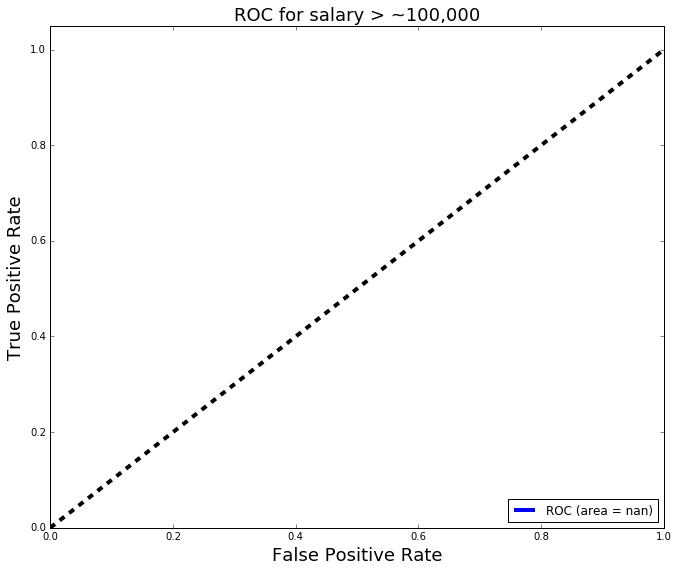

In [29]:
lr_basic = LogisticRegression(solver='liblinear') 
lr_basic_model = lr_basic.fit(Xd_train, yd_train)
lr_basic_ypred = lr_basic_model.predict(Xd_test)

ols = LogisticRegression(solver='liblinear')
model = ols.fit(X_train, y_train)
ypreds = model.predict(X_test)
plot_roc(ypreds, y_test)

#### Problem 5 - Build a vector of prediction from the trained model

In [ ]:
#looking like I was totally unable to do so



# Using K-Nearest Neighbor for imputing missing data

#### Problem 6 - Build a K-NN model (k = 5), to model the inclusion indicator 

The point of this model isn't really to shed more light on the "missingness", but rather to actually impute values into our column of data that contains missing values. Still, it's a good exercise to go through. After you've done the imputation, take a random subset of these imputed values and think about the results, is doing this a good way to fill in values? Would it be easier to do something simpler i.e. take the average for numerical data, or just select some label as fill-in for categorical data?

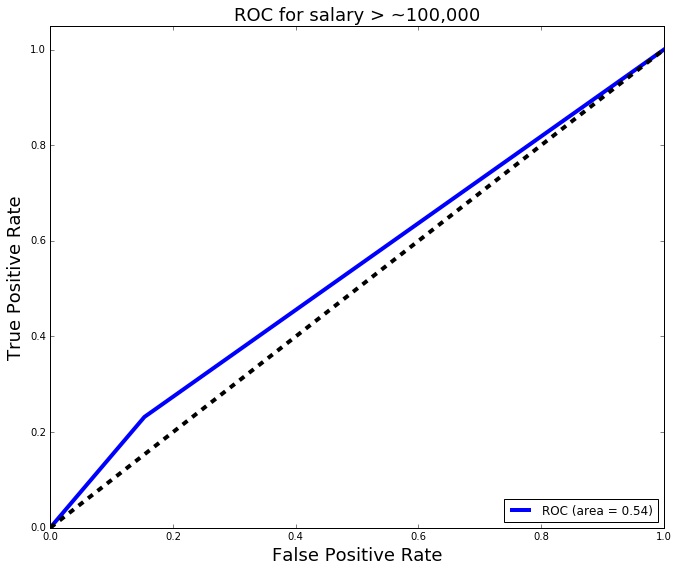

In [34]:
from sklearn.neighbors import KNeighborsClassifier

input_features = ['edu', 'state', 'age']

knn = KNeighborsClassifier(n_neighbors = 5)
knn_model = knn.fit(X_train, y_train)
ypred_knn = knn_model.predict(X_test)


knn_impute = KNeighborsClassifier(n_neighbors = 5)
knn_impute.fit(X, y_train)
knn_pred = knn_impute.predict(X_test)



#but 
plot_roc(knn_pred, y_test)

# Imputing with Random Forest

#### Problem 7 - Build a Random forest to model the inclusion indicator 

Similar to the KNN, this is more about actually doing the imputation. However still a good review/exercise, compare your results with the KNN. How can we objectively measure relative performance? 

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer




# Doing some basic comparisons of results and forecasting efficaciousness

We need to compare our results -- construct ROC scores for each of the 3 methods 

Print the AUC for your non-Bayesian Logistic

Print the AUC for Random Forest

Print the AUC for KNN Impute

**Open Ended Questions** Can we be fairly confident that there is some kind of functional relationship between the indicator variable and the few columns we studied in our data set? Is it obvious that there are probably other factors impacting "missingness" from this data? Which type of "missingness" are we probably in, and what does that say about the state of our missing data and how we should approach modeling on this data set in the future? What further actions can we take to augment this analysis?